In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=9216, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.alexnet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 2506564


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.12101263819510978
Val loss:  0.13147103423657625
train accuracy:  0.5822050290135397
Val accuracy:  0.5739130434782609
Best model at the moment with Val_acc 57.39, saving...
Current time: 2.167 minutes. Time expected till completion: 214.568 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]


train loss:  0.10475018995181735
Val loss:  0.12288702467213507
train accuracy:  0.6402321083172147
Val accuracy:  0.5652173913043478
Current time: 2.447 minutes. Time expected till completion: 119.885 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:01<00:00, 15.00it/s]


train loss:  0.10018104496384958
Val loss:  0.11952686646710271
train accuracy:  0.6499032882011605
Val accuracy:  0.6
Best model at the moment with Val_acc 60.0, saving...
Current time: 2.726 minutes. Time expected till completion: 88.153 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.09404885056978038
Val loss:  0.12196739963863207
train accuracy:  0.6673114119922631
Val accuracy:  0.6
Current time: 2.992 minutes. Time expected till completion: 71.810 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:01<00:00, 15.00it/s]


train loss:  0.0887902897117908
Val loss:  0.14805462593617646
train accuracy:  0.6963249516441006
Val accuracy:  0.5739130434782609
Current time: 3.259 minutes. Time expected till completion: 61.930 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:00<00:00, 15.16it/s]


train loss:  0.08637266755968735
Val loss:  0.16841304198555324
train accuracy:  0.6963249516441006
Val accuracy:  0.5478260869565217
Current time: 3.529 minutes. Time expected till completion: 55.284 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.08156730447908435
Val loss:  0.13924243268759354
train accuracy:  0.730174081237911
Val accuracy:  0.5565217391304348
Current time: 3.806 minutes. Time expected till completion: 50.569 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:01<00:00, 11.79it/s]


train loss:  0.07781315936456566
Val loss:  0.12382908230242522
train accuracy:  0.7437137330754352
Val accuracy:  0.591304347826087
Current time: 4.108 minutes. Time expected till completion: 47.247 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:01<00:00, 12.51it/s]


train loss:  0.07493477030810351
Val loss:  0.13585486567538718
train accuracy:  0.7495164410058027
Val accuracy:  0.5565217391304348
Current time: 4.436 minutes. Time expected till completion: 44.849 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:01<00:00, 11.17it/s]


train loss:  0.0702084090625525
Val loss:  0.14311747291813726
train accuracy:  0.7717601547388782
Val accuracy:  0.5739130434782609
Current time: 4.721 minutes. Time expected till completion: 42.486 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:01<00:00, 11.89it/s]


train loss:  0.06801328483457376
Val loss:  0.1377606176811716
train accuracy:  0.7862669245647969
Val accuracy:  0.6086956521739131
Best model at the moment with Val_acc 60.87, saving...
Current time: 5.022 minutes. Time expected till completion: 40.632 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


train loss:  0.0647237983890728
Val loss:  0.13212384892546614
train accuracy:  0.811411992263056
Val accuracy:  0.5826086956521739
Current time: 5.306 minutes. Time expected till completion: 38.912 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


train loss:  0.061225029151720976
Val loss:  0.19342762076336403
train accuracy:  0.8017408123791102
Val accuracy:  0.46956521739130436
Current time: 5.578 minutes. Time expected till completion: 37.333 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:01<00:00, 13.90it/s]


train loss:  0.059951815710941644
Val loss:  0.15905459160390106
train accuracy:  0.8007736943907157
Val accuracy:  0.46956521739130436
Current time: 5.858 minutes. Time expected till completion: 35.985 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:01<00:00, 14.07it/s]


train loss:  0.05632907513896548
Val loss:  0.21889254463755567
train accuracy:  0.8317214700193424
Val accuracy:  0.4434782608695652
Current time: 6.135 minutes. Time expected till completion: 34.765 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:01<00:00, 14.16it/s]


train loss:  0.0539260523274858
Val loss:  0.1623996428821398
train accuracy:  0.8423597678916828
Val accuracy:  0.5391304347826087
Current time: 6.408 minutes. Time expected till completion: 33.641 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]


train loss:  0.051174149843116565
Val loss:  0.16855388542880181
train accuracy:  0.8423597678916828
Val accuracy:  0.5478260869565217
Current time: 6.684 minutes. Time expected till completion: 32.635 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:01<00:00, 13.35it/s]


train loss:  0.04899776043510875
Val loss:  0.24846887951311858
train accuracy:  0.8539651837524178
Val accuracy:  0.4782608695652174
Current time: 6.968 minutes. Time expected till completion: 31.743 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:01<00:00, 13.90it/s]


train loss:  0.04716775453752141
Val loss:  0.16495633060517517
train accuracy:  0.8520309477756286
Val accuracy:  0.591304347826087
Current time: 7.253 minutes. Time expected till completion: 30.921 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:01<00:00, 13.86it/s]


train loss:  0.042798231952108544
Val loss:  0.17179960906505584
train accuracy:  0.8646034816247582
Val accuracy:  0.5391304347826087
Current time: 7.558 minutes. Time expected till completion: 30.232 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.04078410911721464
Val loss:  0.17063069861868155
train accuracy:  0.8907156673114119
Val accuracy:  0.591304347826087
Current time: 7.853 minutes. Time expected till completion: 29.542 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:01<00:00, 13.90it/s]


train loss:  0.03869338760537958
Val loss:  0.22375698452410492
train accuracy:  0.8897485493230174
Val accuracy:  0.5043478260869565
Current time: 8.145 minutes. Time expected till completion: 28.878 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:01<00:00, 14.05it/s]


train loss:  0.0358391978401453
Val loss:  0.17435055711995
train accuracy:  0.8916827852998066
Val accuracy:  0.6
Current time: 8.443 minutes. Time expected till completion: 28.264 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:01<00:00, 14.69it/s]


train loss:  0.036326232285200974
Val loss:  0.19706980586051942
train accuracy:  0.8868471953578336
Val accuracy:  0.591304347826087
Current time: 8.722 minutes. Time expected till completion: 27.618 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


train loss:  0.030327563646035106
Val loss:  0.20464291624400927
train accuracy:  0.9168278529980658
Val accuracy:  0.591304347826087
Current time: 9.015 minutes. Time expected till completion: 27.046 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:00<00:00, 15.22it/s]


train loss:  0.031000545406912234
Val loss:  0.3259586926387704
train accuracy:  0.9177949709864603
Val accuracy:  0.4782608695652174
Current time: 9.290 minutes. Time expected till completion: 26.441 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:01<00:00, 14.46it/s]


train loss:  0.03411363799402371
Val loss:  0.29116243434988937
train accuracy:  0.913926499032882
Val accuracy:  0.48695652173913045
Current time: 9.565 minutes. Time expected till completion: 25.860 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:01<00:00, 10.47it/s]


train loss:  0.029744652339493284
Val loss:  0.19535875398179758
train accuracy:  0.925531914893617
Val accuracy:  0.591304347826087
Current time: 9.916 minutes. Time expected till completion: 25.498 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:01<00:00, 10.36it/s]


train loss:  0.023772383221322437
Val loss:  0.22785915071549623
train accuracy:  0.9439071566731141
Val accuracy:  0.5652173913043478
Current time: 10.233 minutes. Time expected till completion: 25.053 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:01<00:00, 11.86it/s]


train loss:  0.024218436834948207
Val loss:  0.2226559755594834
train accuracy:  0.9381044487427466
Val accuracy:  0.5478260869565217
Current time: 10.557 minutes. Time expected till completion: 24.633 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:01<00:00, 11.14it/s]


train loss:  0.020873907918373492
Val loss:  0.20904875449512317
train accuracy:  0.9535783365570599
Val accuracy:  0.5565217391304348
Current time: 10.902 minutes. Time expected till completion: 24.267 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


train loss:  0.019489362264841045
Val loss:  0.2191990904186083
train accuracy:  0.9526112185686654
Val accuracy:  0.5565217391304348
Current time: 11.187 minutes. Time expected till completion: 23.773 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:01<00:00, 10.45it/s]


train loss:  0.02132784306050082
Val loss:  0.3326236622489017
train accuracy:  0.9487427466150871
Val accuracy:  0.5565217391304348
Current time: 11.470 minutes. Time expected till completion: 23.287 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:01<00:00, 13.85it/s]


train loss:  0.025049515192377123
Val loss:  0.22082529625167016
train accuracy:  0.9352030947775629
Val accuracy:  0.5739130434782609
Current time: 11.751 minutes. Time expected till completion: 22.810 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.019847552389324404
Val loss:  0.2573077778453412
train accuracy:  0.9545454545454546
Val accuracy:  0.5478260869565217
Current time: 12.024 minutes. Time expected till completion: 22.330 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:01<00:00, 14.02it/s]


train loss:  0.015907969296170395
Val loss:  0.3067886690082757
train accuracy:  0.9632495164410058
Val accuracy:  0.46956521739130436
Current time: 12.296 minutes. Time expected till completion: 21.860 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:01<00:00, 14.00it/s]


train loss:  0.016558488422006773
Val loss:  0.28194870845131254
train accuracy:  0.9690522243713733
Val accuracy:  0.5217391304347826
Current time: 12.570 minutes. Time expected till completion: 21.403 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:01<00:00, 14.08it/s]


train loss:  0.015087572394328001
Val loss:  0.2868237863416257
train accuracy:  0.9661508704061895
Val accuracy:  0.5391304347826087
Current time: 12.846 minutes. Time expected till completion: 20.959 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:01<00:00, 14.59it/s]


train loss:  0.01436068521807154
Val loss:  0.29071399627820305
train accuracy:  0.9709864603481625
Val accuracy:  0.5391304347826087
Current time: 13.118 minutes. Time expected till completion: 20.518 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:00<00:00, 15.01it/s]


train loss:  0.019454417852468688
Val loss:  0.25371769264988275
train accuracy:  0.9526112185686654
Val accuracy:  0.5652173913043478
Current time: 13.389 minutes. Time expected till completion: 20.084 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


train loss:  0.01188667011135384
Val loss:  0.28774430803630663
train accuracy:  0.9758220502901354
Val accuracy:  0.5391304347826087
Current time: 13.666 minutes. Time expected till completion: 19.666 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:01<00:00, 14.77it/s]


train loss:  0.01199528537294332
Val loss:  0.27480139602785525
train accuracy:  0.9709864603481625
Val accuracy:  0.5565217391304348
Current time: 13.940 minutes. Time expected till completion: 19.251 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


train loss:  0.011551422970837822
Val loss:  0.28450705279474675
train accuracy:  0.9806576402321083
Val accuracy:  0.591304347826087
Current time: 14.215 minutes. Time expected till completion: 18.843 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:01<00:00, 14.79it/s]


train loss:  0.010164451157148185
Val loss:  0.3244224602761476
train accuracy:  0.988394584139265
Val accuracy:  0.5130434782608696
Current time: 14.487 minutes. Time expected till completion: 18.438 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:01<00:00, 10.40it/s]


train loss:  0.010863434107221187
Val loss:  0.2917777600495712
train accuracy:  0.9816247582205029
Val accuracy:  0.5652173913043478
Current time: 14.798 minutes. Time expected till completion: 18.086 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


train loss:  0.009907503194077485
Val loss:  0.30604563549808833
train accuracy:  0.9787234042553191
Val accuracy:  0.5652173913043478
Current time: 15.135 minutes. Time expected till completion: 17.767 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


train loss:  0.009313249004787695
Val loss:  0.29911343001801033
train accuracy:  0.9854932301740812
Val accuracy:  0.5565217391304348
Current time: 15.459 minutes. Time expected till completion: 17.433 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:01<00:00, 11.80it/s]


train loss:  0.0074671758734342454
Val loss:  0.2900214143421339
train accuracy:  0.9941972920696325
Val accuracy:  0.5478260869565217
Current time: 15.750 minutes. Time expected till completion: 17.063 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:01<00:00, 14.15it/s]


train loss:  0.014277843718607937
Val loss:  0.30470196125300036
train accuracy:  0.965183752417795
Val accuracy:  0.591304347826087
Current time: 16.079 minutes. Time expected till completion: 16.736 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


train loss:  0.008231318352777309
Val loss:  0.29119167522243833
train accuracy:  0.9893617021276596
Val accuracy:  0.5739130434782609
Current time: 16.371 minutes. Time expected till completion: 16.371 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


train loss:  0.006603984207584121
Val loss:  0.3073512546394182
train accuracy:  0.9961315280464217
Val accuracy:  0.591304347826087
Current time: 16.651 minutes. Time expected till completion: 15.998 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:01<00:00, 13.54it/s]


train loss:  0.007678719402049493
Val loss:  0.2920903392136097
train accuracy:  0.9903288201160542
Val accuracy:  0.5739130434782609
Current time: 16.929 minutes. Time expected till completion: 15.627 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:00<00:00, 15.04it/s]


train loss:  0.008964723119581105
Val loss:  0.31433107438294783
train accuracy:  0.9825918762088974
Val accuracy:  0.5391304347826087
Current time: 17.200 minutes. Time expected till completion: 15.253 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:01<00:00, 14.89it/s]


train loss:  0.009187538721134824
Val loss:  0.3004070471162381
train accuracy:  0.9864603481624759
Val accuracy:  0.5565217391304348
Current time: 17.474 minutes. Time expected till completion: 14.885 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:01<00:00, 14.95it/s]


train loss:  0.006135103500599485
Val loss:  0.32211653642032456
train accuracy:  0.9932301740812379
Val accuracy:  0.5826086956521739
Current time: 17.751 minutes. Time expected till completion: 14.524 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.004746801672988379
Val loss:  0.3186161523927813
train accuracy:  0.9980657640232108
Val accuracy:  0.5739130434782609
Current time: 18.051 minutes. Time expected till completion: 14.183 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]


train loss:  0.004154969290722111
Val loss:  0.3285621518674104
train accuracy:  0.995164410058027
Val accuracy:  0.5478260869565217
Current time: 18.337 minutes. Time expected till completion: 13.833 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:01<00:00, 14.85it/s]


train loss:  0.006522728490050544
Val loss:  0.30398102007482364
train accuracy:  0.9893617021276596
Val accuracy:  0.5565217391304348
Current time: 18.608 minutes. Time expected till completion: 13.475 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:01<00:00, 14.57it/s]


train loss:  0.005678231940333186
Val loss:  0.32947368991115816
train accuracy:  0.995164410058027
Val accuracy:  0.5478260869565217
Current time: 18.880 minutes. Time expected till completion: 13.120 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.004495224150920438
Val loss:  0.36401186365148297
train accuracy:  0.9961315280464217
Val accuracy:  0.5304347826086957
Current time: 19.150 minutes. Time expected till completion: 12.766 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:00<00:00, 15.41it/s]


train loss:  0.0039022929658635917
Val loss:  0.32665374991686447
train accuracy:  0.9961315280464217
Val accuracy:  0.5565217391304348
Current time: 19.420 minutes. Time expected till completion: 12.416 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:01<00:00, 14.98it/s]


train loss:  0.005516047241234124
Val loss:  0.3381511861863344
train accuracy:  0.9961315280464217
Val accuracy:  0.5478260869565217
Current time: 19.690 minutes. Time expected till completion: 12.068 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:01<00:00, 14.62it/s]


train loss:  0.00391126292617181
Val loss:  0.3438564008344775
train accuracy:  0.995164410058027
Val accuracy:  0.5217391304347826
Current time: 19.961 minutes. Time expected till completion: 11.723 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


train loss:  0.004778473780181856
Val loss:  0.34890040172182996
train accuracy:  0.9941972920696325
Val accuracy:  0.5739130434782609
Current time: 20.231 minutes. Time expected till completion: 11.380 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:00<00:00, 15.12it/s]


train loss:  0.0053145553651493226
Val loss:  0.33465354986812756
train accuracy:  0.9932301740812379
Val accuracy:  0.5652173913043478
Current time: 20.501 minutes. Time expected till completion: 11.039 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.0045909389868789355
Val loss:  0.38058754419503005
train accuracy:  0.995164410058027
Val accuracy:  0.5478260869565217
Current time: 20.769 minutes. Time expected till completion: 10.699 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:01<00:00, 14.67it/s]


train loss:  0.00566796835709401
Val loss:  0.39361945675766985
train accuracy:  0.9912959381044487
Val accuracy:  0.5391304347826087
Current time: 21.041 minutes. Time expected till completion: 10.363 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:01<00:00, 14.34it/s]


train loss:  0.010852668312730851
Val loss:  0.33622731689525687
train accuracy:  0.9835589941972921
Val accuracy:  0.5478260869565217
Current time: 21.311 minutes. Time expected till completion: 10.029 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.004747082503279221
Val loss:  0.3676684646502785
train accuracy:  0.995164410058027
Val accuracy:  0.5391304347826087
Current time: 21.584 minutes. Time expected till completion: 9.697 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:01<00:00, 14.20it/s]


train loss:  0.003281403918121446
Val loss:  0.383705742203671
train accuracy:  0.9970986460348162
Val accuracy:  0.5391304347826087
Current time: 21.855 minutes. Time expected till completion: 9.366 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


train loss:  0.0027301899163994572
Val loss:  0.3569796450760054
train accuracy:  0.9990328820116054
Val accuracy:  0.5478260869565217
Current time: 22.126 minutes. Time expected till completion: 9.037 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:01<00:00, 14.79it/s]


train loss:  0.002476019268201095
Val loss:  0.38843430669411366
train accuracy:  0.9980657640232108
Val accuracy:  0.5217391304347826
Current time: 22.396 minutes. Time expected till completion: 8.709 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:01<00:00, 14.30it/s]


train loss:  0.00411751106803844
Val loss:  0.3587398561446563
train accuracy:  0.9961315280464217
Val accuracy:  0.5739130434782609
Current time: 22.667 minutes. Time expected till completion: 8.384 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:01<00:00, 14.57it/s]


train loss:  0.004009888557490214
Val loss:  0.36880347003107483
train accuracy:  0.995164410058027
Val accuracy:  0.5478260869565217
Current time: 22.938 minutes. Time expected till completion: 8.059 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.003983366749892497
Val loss:  0.35240917192853016
train accuracy:  0.9961315280464217
Val accuracy:  0.5304347826086957
Current time: 23.212 minutes. Time expected till completion: 7.737 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:01<00:00, 14.04it/s]


train loss:  0.002140704872279394
Val loss:  0.3875869590303172
train accuracy:  0.9990328820116054
Val accuracy:  0.5391304347826087
Current time: 23.485 minutes. Time expected till completion: 7.416 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:01<00:00, 14.02it/s]


train loss:  0.0037504611375860555
Val loss:  0.3676292506249055
train accuracy:  0.9970986460348162
Val accuracy:  0.5652173913043478
Current time: 23.757 minutes. Time expected till completion: 7.096 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:01<00:00, 14.04it/s]


train loss:  0.0019297285403277657
Val loss:  0.3805227129355721
train accuracy:  0.9990328820116054
Val accuracy:  0.5217391304347826
Current time: 24.028 minutes. Time expected till completion: 6.777 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:01<00:00, 13.93it/s]


train loss:  0.001940803781802076
Val loss:  0.3860600327667983
train accuracy:  0.9990328820116054
Val accuracy:  0.5478260869565217
Current time: 24.300 minutes. Time expected till completion: 6.459 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.002893001357072287
Val loss:  0.38782957338768503
train accuracy:  0.9980657640232108
Val accuracy:  0.5478260869565217
Current time: 24.573 minutes. Time expected till completion: 6.143 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


train loss:  0.002623190456187097
Val loss:  0.35921020183874214
train accuracy:  0.9980657640232108
Val accuracy:  0.5652173913043478
Current time: 24.851 minutes. Time expected till completion: 5.829 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:01<00:00, 14.12it/s]


train loss:  0.002684331493832962
Val loss:  0.3870685612377913
train accuracy:  0.9980657640232108
Val accuracy:  0.5478260869565217
Current time: 25.133 minutes. Time expected till completion: 5.517 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:01<00:00, 14.88it/s]


train loss:  0.002463586657892708
Val loss:  0.38129893917104474
train accuracy:  0.9980657640232108
Val accuracy:  0.5478260869565217
Current time: 25.403 minutes. Time expected till completion: 5.203 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:01<00:00, 14.95it/s]


train loss:  0.0028590760541519346
Val loss:  0.3846494701893433
train accuracy:  0.9970986460348162
Val accuracy:  0.5739130434782609
Current time: 25.674 minutes. Time expected till completion: 4.890 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:00<00:00, 15.18it/s]


train loss:  0.0024429130963184035
Val loss:  0.38458555755407914
train accuracy:  0.9970986460348162
Val accuracy:  0.5478260869565217
Current time: 25.944 minutes. Time expected till completion: 4.578 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.0024745685778291083
Val loss:  0.374573963491813
train accuracy:  0.9980657640232108
Val accuracy:  0.5565217391304348
Current time: 26.213 minutes. Time expected till completion: 4.267 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.002265622864128991
Val loss:  0.3743549213461254
train accuracy:  0.9980657640232108
Val accuracy:  0.5478260869565217
Current time: 26.482 minutes. Time expected till completion: 3.957 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:00<00:00, 15.01it/s]


train loss:  0.0014276195815030297
Val loss:  0.37475716212521426
train accuracy:  0.9990328820116054
Val accuracy:  0.5391304347826087
Current time: 26.753 minutes. Time expected till completion: 3.648 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:00<00:00, 15.01it/s]


train loss:  0.0013881309954163563
Val loss:  0.38229875383169754
train accuracy:  0.9990328820116054
Val accuracy:  0.5565217391304348
Current time: 27.023 minutes. Time expected till completion: 3.340 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:00<00:00, 15.15it/s]


train loss:  0.0015785855970362212
Val loss:  0.38833922257889875
train accuracy:  0.9990328820116054
Val accuracy:  0.5652173913043478
Current time: 27.299 minutes. Time expected till completion: 3.033 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  0.0021827357716572866
Val loss:  0.37919449274954586
train accuracy:  0.9980657640232108
Val accuracy:  0.5739130434782609
Current time: 27.576 minutes. Time expected till completion: 2.727 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:01<00:00, 14.89it/s]


train loss:  0.0020874086420243827
Val loss:  0.3828108768100324
train accuracy:  0.9980657640232108
Val accuracy:  0.5304347826086957
Current time: 27.853 minutes. Time expected till completion: 2.422 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:01<00:00, 14.64it/s]


train loss:  0.0021240624121056572
Val loss:  0.38242197691098506
train accuracy:  0.9980657640232108
Val accuracy:  0.5565217391304348
Current time: 28.133 minutes. Time expected till completion: 2.118 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


train loss:  0.0019252568467759312
Val loss:  0.3897499764095182
train accuracy:  0.9980657640232108
Val accuracy:  0.5391304347826087
Current time: 28.417 minutes. Time expected till completion: 1.814 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:01<00:00, 14.36it/s]


train loss:  0.0012209318436298751
Val loss:  0.38351212273473323
train accuracy:  0.9990328820116054
Val accuracy:  0.5652173913043478
Current time: 28.698 minutes. Time expected till completion: 1.510 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.0013030644115425351
Val loss:  0.3977125206719274
train accuracy:  0.9990328820116054
Val accuracy:  0.5478260869565217
Current time: 28.985 minutes. Time expected till completion: 1.208 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:01<00:00, 12.68it/s]


train loss:  0.0012738692142314414
Val loss:  0.3996190581632697
train accuracy:  0.9990328820116054
Val accuracy:  0.5478260869565217
Current time: 29.282 minutes. Time expected till completion: 0.906 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:01<00:00, 14.39it/s]


train loss:  0.0019291156840254417
Val loss:  0.39472285327704054
train accuracy:  0.9980657640232108
Val accuracy:  0.5478260869565217
Current time: 29.575 minutes. Time expected till completion: 0.604 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:01<00:00, 13.93it/s]


train loss:  0.0010586041138826948
Val loss:  0.41318259783413097
train accuracy:  0.9990328820116054
Val accuracy:  0.5304347826086957
Current time: 29.851 minutes. Time expected till completion: 0.302 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:01<00:00, 10.13it/s]


train loss:  0.0015592862628234822
Val loss:  0.3869271993637085
train accuracy:  0.9980657640232108
Val accuracy:  0.5565217391304348
Saving model 2 checkpoint


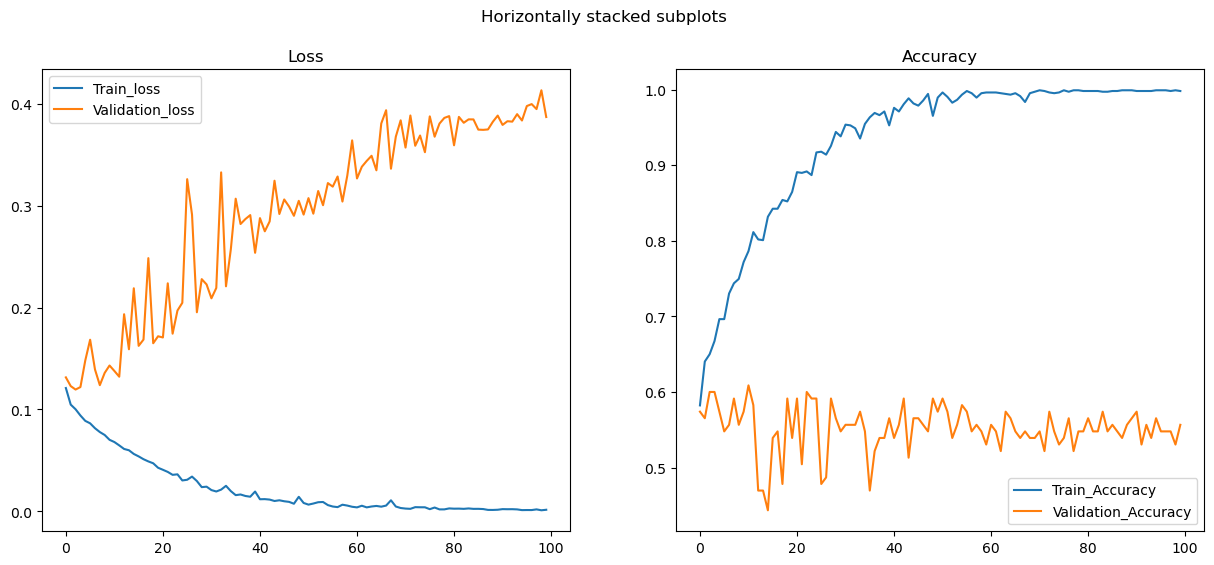

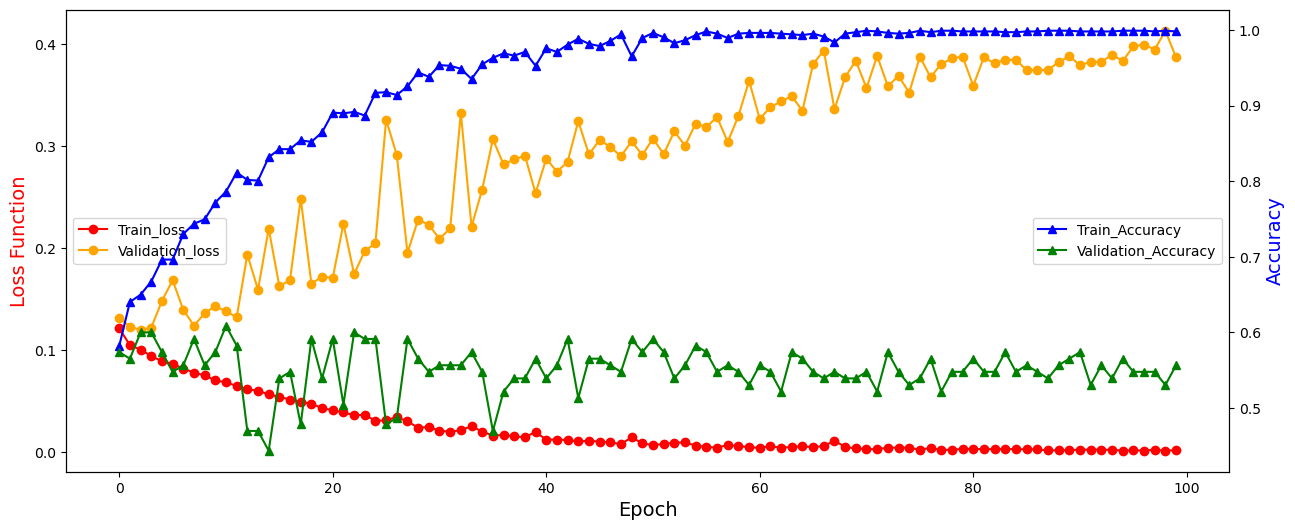

Current time: 30.380 minutes. Time expected till completion: 0.000 minutes
Finished training in: 30.380 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6086956521739131

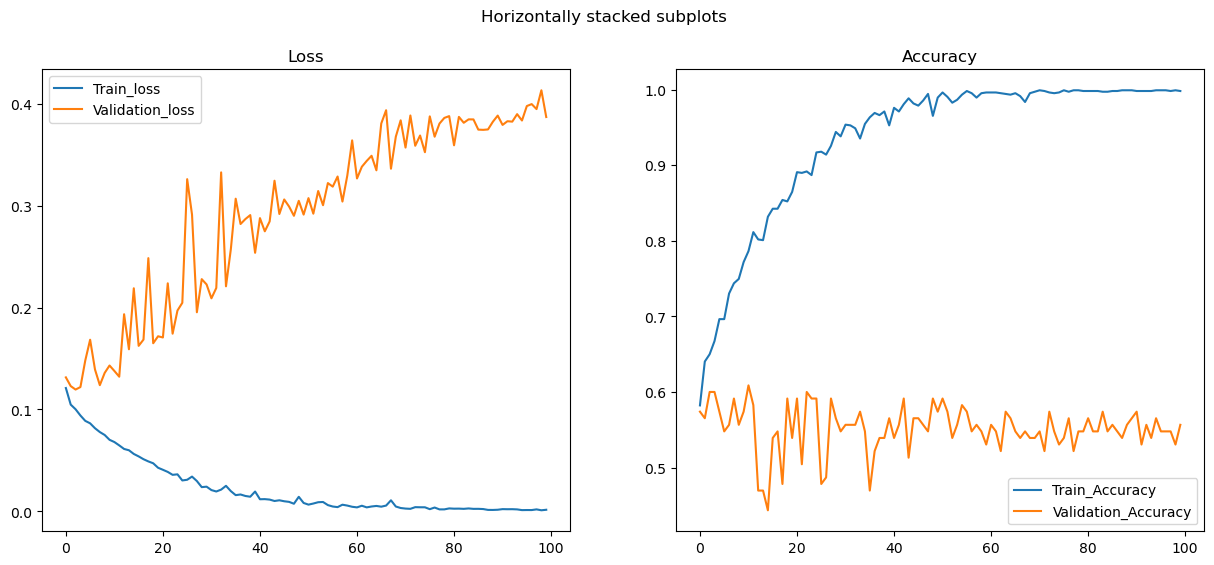

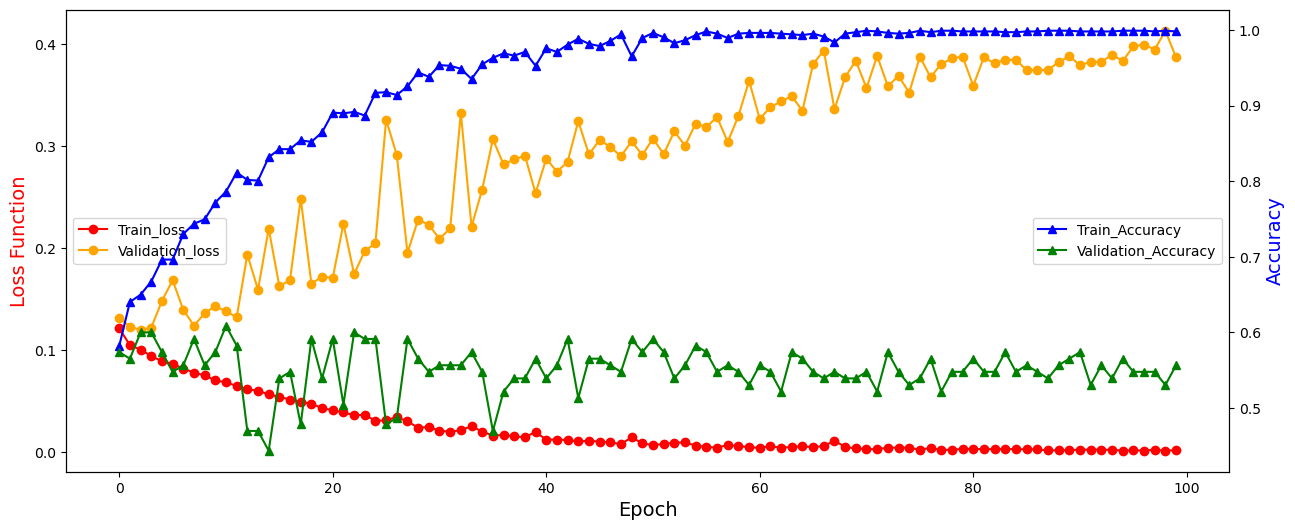

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:09<00:00, 14.30it/s]


Accuracy of the network on the 1034 Train instances: 99.90328820116054%


100%|██████████| 15/15 [00:00<00:00, 15.06it/s]

Accuracy of the network on the 115 Validation instances: 55.65217391304348%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:09<00:00, 38.49it/s]


(array([0, 1, 2, 3]), array([164, 160,  52,   4], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_AlexNet_prediction.csv")

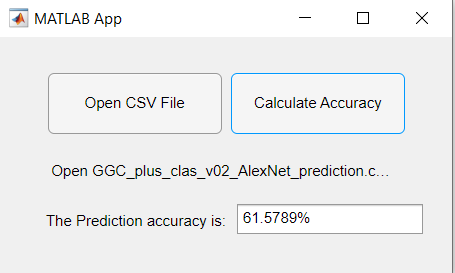

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:09<00:00, 13.88it/s]


Accuracy of the network on the 1034 Train instances: 82.1083172147002%


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]

Accuracy of the network on the 115 Validation instances: 60.869565217391305%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:04<00:00, 77.98it/s]


(array([0, 1, 2]), array([188, 157,  35], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_AlexNet_best_prediction.csv")

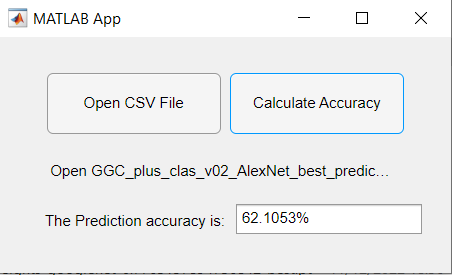